In [3]:
import numpy as np
import pandas as pd
import os
import pickle
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.decomposition import PCA
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold
import seaborn as sns

In [54]:
data = pd.read_csv("SIFI_full.csv")
distance_data = pd.read_csv("distances_individual_Tpeak.csv")
data = data[data["FlashType"] == 2]
data = data[data["NrBeeps"] == 2]
data = data.merge(distance_data, on="participant_id")

In [55]:
data

,participant_id,FlashType,NrBeeps,correct,rt,correct_abs,correct_rel,rt_abs,rt_rel,rt_Cod,bl_correct,bl_rt,CFF,sex,age,"Dist to A1, LH","Dist to A1, RH","Dist to V1, LH","Dist to V1, RH"
0,13000,2,2,0.035714,0.673689,-0.730952,-0.952174,0.133509,0.165399,0.384151,0.766667,0.807198,0.378,1,20.7,26.177394,34.728311,77.166546,80.322080
1,13159,2,2,0.600000,0.618450,-0.193103,-0.243172,0.036737,0.056071,0.201571,0.793103,0.655188,0.798,0,20.9,23.953569,14.713486,75.118177,74.995011
2,13227,2,2,0.034483,0.564893,-0.265517,-0.882117,0.267626,0.321465,0.652510,0.300000,0.832520,0.336,1,21.3,29.358840,32.810759,83.844544,88.817904
3,13774,2,2,0.133333,0.739671,-0.694253,-0.837876,0.022611,0.029662,0.082990,0.827586,0.762282,0.336,0,20.3,28.180178,32.345026,78.961423,77.111296
4,14351,2,2,0.296296,0.804682,-0.634738,-0.681024,-0.011936,-0.015057,-0.051853,0.931034,0.792746,0.294,1,25.5,30.989983,34.022575,83.287033,79.857151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,96269,2,2,0.206897,0.951003,-0.724138,-0.776943,0.044633,0.044829,0.063946,0.931034,0.995637,0.336,0,22.9,28.611753,42.066613,72.824165,77.064171
254,96838,2,2,0.222222,0.587074,-0.570881,-0.718900,0.060749,0.093775,0.488051,0.793103,0.647823,0.336,0,30.0,18.237076,33.140702,68.145965,75.492261
255,97515,2,2,0.034483,0.710017,-0.758621,-0.955317,0.033466,0.045013,0.116021,0.793103,0.743483,0.294,1,23.2,33.923593,38.150136,84.444098,84.063680
256,98735,2,2,0.000000,0.712788,-0.733333,-0.998638,0.435913,0.379484,1.123012,0.733333,1.148702,0.294,0,21.0,42.893042,39.881059,85.877711,84.729887


<Axes: xlabel='correct_rel', ylabel='Count'>

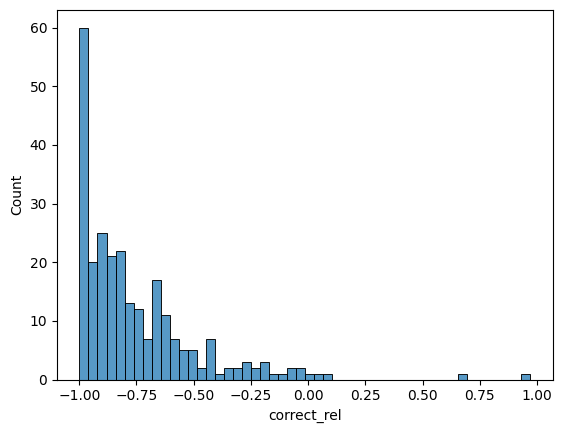

In [56]:
sns.histplot(data["correct_rel"], bins = 50)

In [57]:
correct_rel = data["correct_rel"]
rt_Cod = data["rt_Cod"]

In [58]:
data = data.drop(["participant_id","correct", "rt","correct_abs", "rt_abs", "correct_rel", "rt_Cod","rt_rel", "bl_correct","bl_rt", "CFF", "NrBeeps", "FlashType", "Dist to A1, RH", "Dist to V1, RH"], axis=1, index=None) # "Dist to V1, RH", "Dist to A1, RH", "Dist to A1, LH", "dist_ratio_R", "dist_ratio_L"

In [59]:
data

,sex,age,"Dist to A1, LH","Dist to V1, LH"
0,1,20.7,26.177394,77.166546
1,0,20.9,23.953569,75.118177
2,1,21.3,29.358840,83.844544
3,0,20.3,28.180178,78.961423
4,1,25.5,30.989983,83.287033
...,...,...,...,...
253,0,22.9,28.611753,72.824165
254,0,30.0,18.237076,68.145965
255,1,23.2,33.923593,84.444098
256,0,21.0,42.893042,85.877711


## Pipeline

In [60]:
# cat_features = data.columns[:2].to_list()
# # ord_features = [data_flash1.columns[0]]
num_features = data.columns[1:].to_list()

In [61]:
data.columns

Index(['sex', 'age', 'Dist to A1, LH', 'Dist to V1, LH'], dtype='object')

In [62]:
whiten = Pipeline(
    steps = [("whiten", StandardScaler())]
)

cat_encoder = Pipeline(
    steps = [("cat_encoder", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat_encoder", cat_encoder,  ["sex"]),
        ("whiten", whiten, num_features)
    ]
)



In [63]:
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
svr = svm.SVR(kernel = "linear", epsilon = 0.2)
svr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('svr', svr)
])

rf = RandomForestRegressor(random_state=42)

# Define the pipeline with Random Forests
rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', rf)
])

gb = GradientBoostingRegressor(random_state=42)
gb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('gb', gb)
])

from sklearn.linear_model import QuantileRegressor
qr = QuantileRegressor(quantile=0.9, alpha=0, solver='highs')
qr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('qr', qr)
])

## 5-fold Cross-validation

In [64]:
X_train, X_test, y_train, y_test = train_test_split(data, correct_rel, test_size=0.25, random_state=42)

In [65]:
cat_feature_names = ["Sex_0", "Sex_1"]
feature_names = cat_feature_names + list(num_features)

In [68]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
cv_results = cross_validate(svr_pipe, X_train, y_train, cv=cv, scoring=['r2', 'neg_mean_squared_error'], return_estimator =True, n_jobs = -1)

In [69]:
print("Mean R2 across folds: ", np.mean(cv_results['test_r2']))
print("Mean MSE across folds: ", np.mean(cv_results['test_neg_mean_squared_error']))

Mean R2 across folds:  -0.026827625169259538
Mean MSE across folds:  -0.08844977221237182


In [70]:
coefs = pd.DataFrame(
    [
        est[-1].coef_[0] * est[:-1].transform(X_train.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_results["estimator"], cv.split(X_train, y_train))
    ],
    columns = feature_names
)

Text(0.5, 1.0, 'Coefficient importance and its variability')

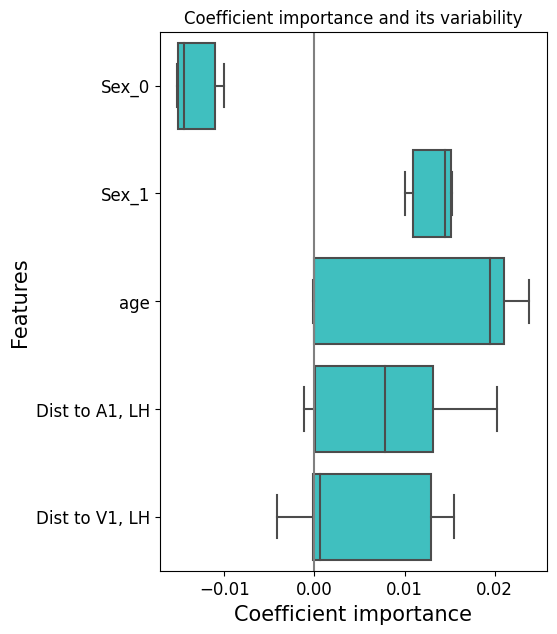

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

fig, ax = plt.subplots(figsize=(5, 7))
sns.boxplot(data=coefs.iloc[:, :100], orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
ax.set_ylabel("Features", fontsize = 15)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='x', labelsize= 12) 
ax.tick_params(axis='y', labelsize= 12) 
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")

## Check predictions

In [25]:
trained_model = svr_pipe.fit(X_train, y_train)

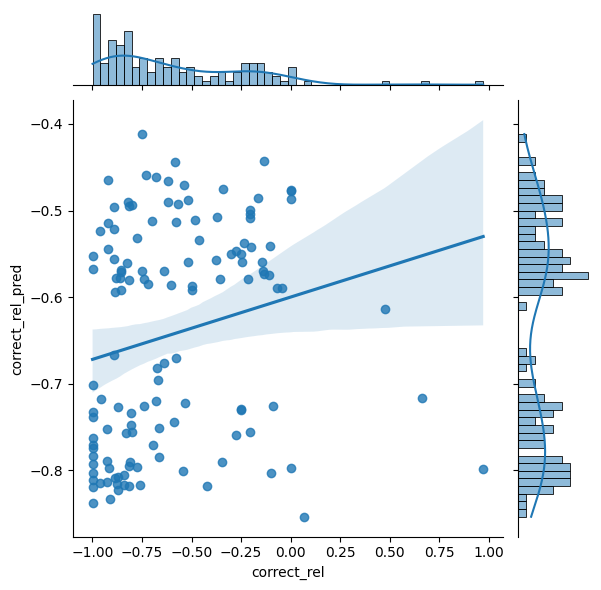

In [26]:
y_pred = trained_model.predict(X_test)
test_pred_df = pd.DataFrame({"correct_rel": y_test, "correct_rel_pred": y_pred})
sns.jointplot(data=test_pred_df, x="correct_rel", y="correct_rel_pred", kind="reg", marginal_kws={'bins': 50})

<Axes: xlabel='correct_rel_pred', ylabel='Count'>

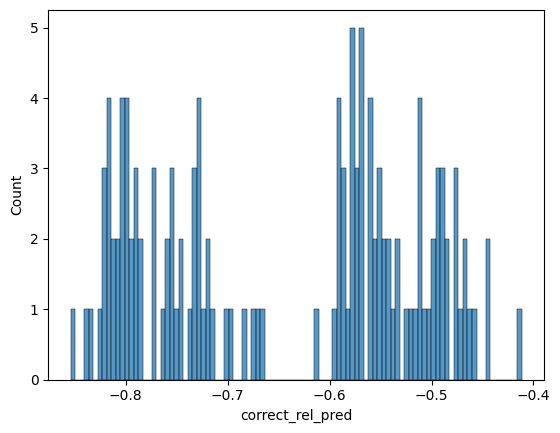

In [27]:
sns.histplot(test_pred_df["correct_rel_pred"], bins = 100)

## Model diagnostics

In [28]:
y_train_pred = trained_model.predict(X_train)

In [29]:
from sklearn.metrics import r2_score

print("R squared: {}".format(r2_score(y_true=y_train,y_pred=y_train_pred)))

R squared: 0.21339258848020404


In [30]:
residuals = y_train.values-y_train_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))

Mean of Residuals 0.005483241615934408


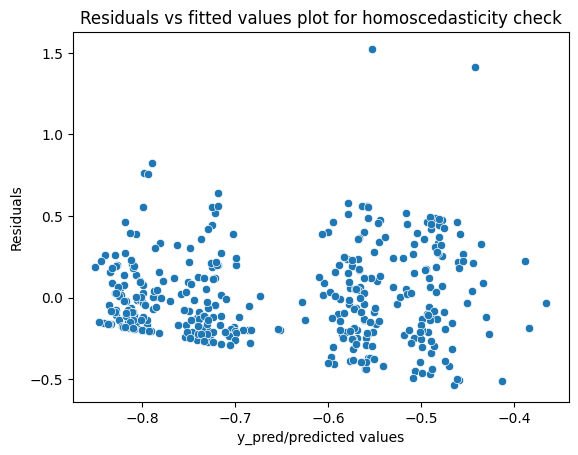

In [31]:
residuals_train = pd.DataFrame({"y_train_pred": y_train_pred, "residuals": residuals})

p = sns.scatterplot(residuals_train, x = "y_train_pred", y = "residuals")
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

In [47]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X_train)
lzip(name, test)

[('F statistic', 1.0388048724004102), ('p-value', 0.3559351667869693)]

## Permutation feature importance

In [32]:
from sklearn.inspection import permutation_importance

perm_acc = permutation_importance(trained_model, X_test, y_test,n_repeats=10000, random_state=42, n_jobs = -1)
perm_sorted_idx = perm_acc.importances_mean
perm_std = perm_acc.importances_std
null_dist_coefs = perm_acc.importances

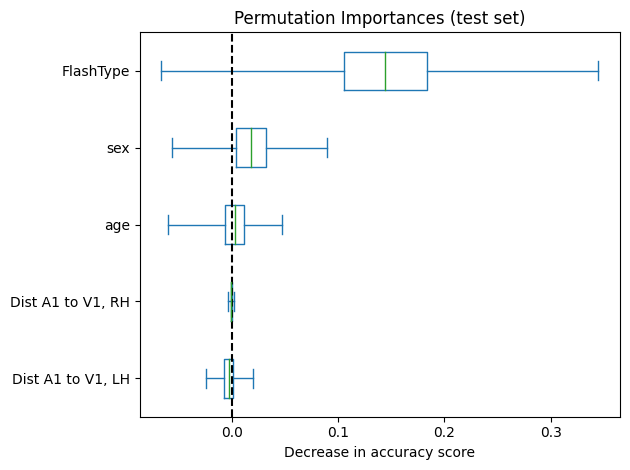

In [33]:
sorted_importances_idx = perm_acc.importances_mean.argsort()
importances = pd.DataFrame(
    perm_acc.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()